# **This tutorial will guide you through implementing a simplified version of ResNet (Residual Network) in PyTorch. We will build a ResNet-18 model and train it on the CIFAR-10 dataset.**

**Step 1: Import Required Libraries, Load and Preprocess CIFAR-10 Dataset.**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Step 2: Build ResNet-18 Model**

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

**Step 3: Train and Evaluate the Model**

Epoch 1: Train Loss: 0.7694, Train Acc: 73.16% | Val Loss: 0.7038, Val Acc: 75.74%
Epoch 2: Train Loss: 0.6499, Train Acc: 77.40% | Val Loss: 0.6545, Val Acc: 77.35%
Epoch 3: Train Loss: 0.5820, Train Acc: 80.01% | Val Loss: 0.6002, Val Acc: 79.42%
Epoch 4: Train Loss: 0.5232, Train Acc: 81.86% | Val Loss: 0.5532, Val Acc: 80.87%
Epoch 5: Train Loss: 0.4776, Train Acc: 83.55% | Val Loss: 0.5342, Val Acc: 81.41%
Epoch 6: Train Loss: 0.4494, Train Acc: 84.37% | Val Loss: 0.4799, Val Acc: 83.34%
Epoch 7: Train Loss: 0.4152, Train Acc: 85.67% | Val Loss: 0.5342, Val Acc: 81.96%
Epoch 8: Train Loss: 0.3866, Train Acc: 86.53% | Val Loss: 0.4561, Val Acc: 84.47%
Epoch 9: Train Loss: 0.3625, Train Acc: 87.35% | Val Loss: 0.4317, Val Acc: 85.34%
Epoch 10: Train Loss: 0.3379, Train Acc: 88.30% | Val Loss: 0.4262, Val Acc: 85.56%


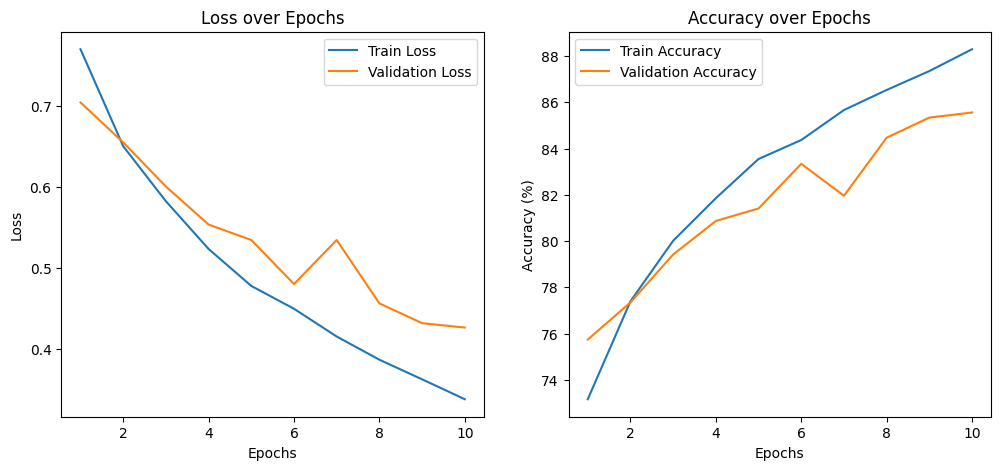

In [16]:
def train_model(model, trainloader, testloader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(testloader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

train_model(model, trainloader, testloader, epochs=10, lr=0.001)